# 求职搜索 VII：McCall劳动者的Q学习

## 概述

本讲介绍一种强大的机器学习方法——Q学习。

{cite}`Sutton_2018`对Q学习和其他各种统计学习方法进行了详细介绍。

Q学习算法融合了两个关键思想：

* 动态规划的原理
* 最小二乘法的递归形式，也称为[时序差分学习 (Temporal Difference Learning or TD Learning)](https://rl.qiwihui.com/zh-cn/latest/partI/chapter6/temporal_difference_learning.html)

在本讲中，我们将Q学习算法应用到McCall求职模型中，探讨劳动者如何通过这种方法做出最优决策。

我们还将扩展模型，考虑劳动者不仅可以接受或拒绝工作机会，还可以选择辞去当前工作的情况。

与我们在 {doc}`quantecon 讲座 <mccall_model>` 中学习的 McCall 劳动者模型的动态规划方法相比，Q-学习算法的一个显著特点是：
劳动者不需要完全了解

* 工资是如何随机生成的
* 接受或拒绝工作机会会带来什么样的奖励

Q-学习算法通过统计学习方法来获取这些信息，这通常可以简化为某种形式的最小二乘法。

在讨论统计学习时，我们需要明确指出学习的目标是什么。

对于Q-学习来说，学习的对象不是动态规划中常见的价值函数，尽管两者密切相关。

在我们研究的有限状态、有限动作环境中，学习目标是一个称为**Q-表** (Q-table) 的结构，它是Q-函数 (Q-function) 在有限集合上的具体表现形式。

这些Q-函数（或Q-表）有时也被称为质量函数或质量表。

Q-表的结构很直观：行代表智能体可能处于的各种状态，列代表在每个状态下可以采取的不同行动。

算法的核心是一个类似贝尔曼方程的等式，但它与我们在{doc}`McCall模型讲座<mccall_model>`中看到的贝尔曼方程有所不同。

在本讲座中，我们将学习一些关于：

* 与马尔可夫决策问题相关的**Q-函数**或**质量函数**，其最优值函数满足贝尔曼方程

* **时序差分学习**，Q-学习算法的一个关键组成部分

像往常一样，让我们先导入一些 Python 模块。

In [1]:
!pip install quantecon

In [2]:
import numpy as np

from numba import jit, float64, int64
from numba.experimental import jitclass
from quantecon.distributions import BetaBinomial

import matplotlib.pyplot as plt
import matplotlib as mpl
FONTPATH = "fonts/SourceHanSerifSC-SemiBold.otf"
mpl.font_manager.fontManager.addfont(FONTPATH)
plt.rcParams['font.family'] = ['Source Han Serif SC']

np.random.seed(123)

## McCall 模型回顾

我们首先回顾在{doc}`这个 quantecon 讲座 <mccall_model>`中描述的 McCall 模型。

我们将计算一个最优值函数和实现该值的策略。

我们最终会将这个最优策略与 Q-learning McCall 劳动者所学到的进行比较。

McCall 模型的特征由参数 $\beta,c$ 和已知的工资分布 $F$ 来描述。

McCall 劳动者想要最大化预期的终身收入折现总和

$$
\mathbb{E} \sum_{t=0}^{\infty} \beta^t y_t
$$

劳动者的收入 $y_t$ 在就业时等于他的工资 $w$，在失业时等于失业补助 $c$。

对于刚收到工资offer $w$ 并正在决定是接受还是拒绝的 McCall 劳动者来说，最优值 $V\left(w\right)$ 满足贝尔曼方程

$$
V\left(w\right)=\max_{\text{accept, reject}}\;\left\{ \frac{w}{1-\beta},c+\beta\int V\left(w'\right)dF\left(w'\right)\right\}
$$ (eq_mccallbellman)

为了与Q-学习的结果进行比较基准，我们首先近似最优值函数。

在有限离散状态空间中，可能的状态由$\{1,2,...,n\}$索引，我们对价值函数$v\in\mathbb{R}^{n}$做一个初始猜测，然后对贝尔曼方程进行迭代：

$$
v^{\prime}(i)=\max \left\{\frac{w(i)}{1-\beta}, c+\beta \sum_{1 \leq j \leq n} v(j) q(j)\right\} \quad \text { for } i=1, \ldots, n
$$

让我们使用{doc}`这个quantecon讲座 <mccall_model>`中的Python代码。

我们使用一个名为`VFI`的Python方法，通过价值函数迭代来计算最优值函数。

我们构造一个假设的工资分布，并用以下Python代码绘制：

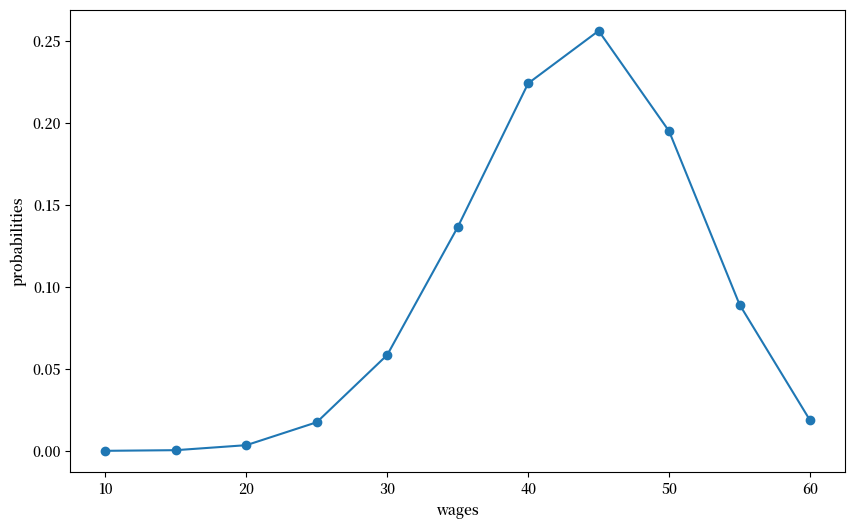

In [3]:
n, a, b = 10, 200, 100                        # default parameters
q_default = BetaBinomial(n, a, b).pdf()       # default choice of q

w_min, w_max = 10, 60
w_default = np.linspace(w_min, w_max, n+1)

# plot distribution of wage offer
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(w_default, q_default, '-o', label='$q(w(i))$')
ax.set_xlabel('wages')
ax.set_ylabel('probabilities')

plt.show()

接下来我们将通过对贝尔曼方程进行迭代收敛来计算劳动者的最优价值函数。

然后我们将绘制贝尔曼算子的各种迭代结果。

In [4]:
mccall_data = [
    ('c', float64),      # 失业补偿
    ('β', float64),      # 贴现因子
    ('w', float64[:]),   # 工资值数组，w[i] = 状态i下的工资
    ('q', float64[:]),   # 概率数组
]


@jitclass(mccall_data)
class McCallModel:

    def __init__(self, c=25, β=0.99, w=w_default, q=q_default):

        self.c, self.β = c, β
        self.w, self.q = w, q

    def state_action_values(self, i, v):
        """
        状态-行动对的值。
        """
        # 简化名称
        c, β, w, q = self.c, self.β, self.w, self.q
        # 评估每个状态-行动对的值
        # 考虑行动： 接受或拒绝当前offer
        accept = w[i] / (1 - β)
        reject = c + β * np.sum(v * q)

        return np.array([accept, reject])

    def VFI(self, eps=1e-5, max_iter=500):
        """
        找到最优价值函数。
        """

        n = len(self.w)
        v = self.w / (1 - self.β)
        v_next = np.empty_like(v)
        flag=0

        for i in range(max_iter):
            for j in range(n):
                v_next[j] = np.max(self.state_action_values(j, v))

            if np.max(np.abs(v_next - v))<=eps:
                flag=1
                break
            v[:] = v_next

        return v, flag

def plot_value_function_seq(mcm, ax, num_plots=8):
    """
    绘制一系列价值函数。

        * mcm: McCallModel的实例
        * ax: 用于绘图的matplotlib轴对象

    """

    n = len(mcm.w)
    v = mcm.w / (1 - mcm.β)
    v_next = np.empty_like(v)
    for i in range(num_plots):
        ax.plot(mcm.w, v, '-', alpha=0.4, label=f"iterate {i}")
        # 更新猜测值
        for i in range(n):
            v_next[i] = np.max(mcm.state_action_values(i, v))
        v[:] = v_next  # 将内容复制到v中

    ax.legend(loc='lower right')

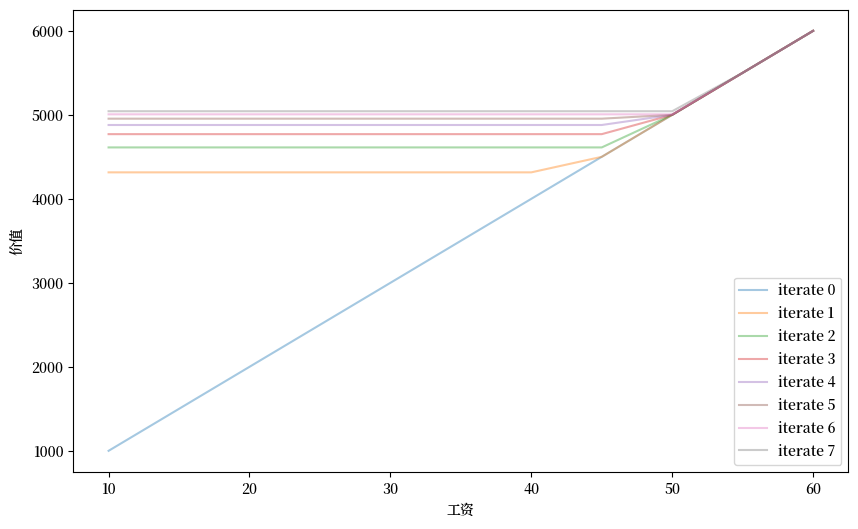

In [5]:
mcm = McCallModel()
valfunc_VFI, flag = mcm.VFI()

fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('工资')
ax.set_ylabel('价值')
plot_value_function_seq(mcm, ax)
plt.show()

接下来我们将打印出迭代序列的极限值。

这是通过价值函数迭代得到的McCall劳动者价值函数的近似值。

在我们完成Q学习之后，我们将使用这个值函数作为基准。

In [6]:
print(valfunc_VFI)

[5322.27935875 5322.27935875 5322.27935875 5322.27935875 5322.27935875
 5322.27935875 5322.27935875 5322.27935875 5322.27935875 5500.
 6000.        ]


## 隐含质量函数 $Q$

**质量函数** $Q$ 将状态-动作对映射为最优值。

它们与最优值函数紧密相连。

但价值函数仅是状态的函数，而不包含动作。

对于每个给定状态，质量函数给出从该状态开始可以达到的最优值列表，列表的每个组成部分表示可以采取的一种可能动作。

对于我们的McCall劳动者模型，假设有有限的可能工资集合：

* 状态空间 $\mathcal{W}=\{w_1,w_2,...,w_n\}$ 由整数 $1,2,...,n$ 索引

* 动作空间为 $\mathcal{A}=\{\text{accept}, \text{reject}\}$

令 $a \in \mathcal{A}$ 为两个可能动作之一，即接受或拒绝。

对于我们的McCall劳动者，最优Q函数 $Q(w,a)$ 等于一个此前失业的劳动者在手头有offer $w$ 时，如果他采取动作 $a$ 所能获得的最大价值。

$Q(w,a)$ 的这个定义假设劳动者在随后的时期会采取最优行动。

我们的 McCall 劳动者的最优 Q-函数满足

$$
\begin{aligned}
Q\left(w,\text{accept}\right) & =\frac{w}{1-\beta} \\
Q\left(w,\text{reject}\right) & =c+\beta\int\max_{\text{accept, reject}}\left\{ \frac{w'}{1-\beta},Q\left(w',\text{reject}\right)\right\} dF\left(w'\right)
\end{aligned}
$$ (eq:impliedq)

注意，系统{eq}`eq:impliedq`的第一个方程假设在个体接受了一个报价后，他将来不会拒绝同样的报价。

这些方程与我们在{doc}`这个 quantecon 讲座 <mccall_model>`中研究的劳动者最优值函数的贝尔曼方程是一致的。

显然，在那个讲座中描述的最优值函数 $V(w)$ 与我们的 Q-函数有如下关系：

$$
V(w) = \max_{\textrm{accept},\textrm{reject}} \left\{ Q(w, \text{accept} \right), Q\left(w,\text{reject} \right)\}
$$

如果我们观察系统{eq}`eq:impliedq`中的第二个方程，我们注意到由于工资过程在时间上是独立同分布的，$Q\left(w,\text{reject}\right)$，方程右侧与当前状态$w$无关。

因此我们可以将其表示为一个标量

$$ Q_r := Q\left(w,\text{reject}\right) \quad \forall \, w\in\mathcal{W}.
$$

这一事实为我们提供了一种替代方案，而且事实证明，在这种情况下，这是一种更快的方法来计算McCall劳动者模型的最优值函数和相关的最优策略。

与我们上面使用的价值函数迭代不同，我们可以对系统{eq}`eq:impliedq`中第二个方程的一个版本进行迭代直至收敛，该方程将$Q_r$的估计值映射为改进的估计值$Q_r'$：

$$
Q_{r}^\prime=c+\beta\int\max_{\text{}}\left\{ \frac{w'}{1-\beta},Q_{r}\right\} dF\left(w'\right)
$$

在$Q_r$序列收敛后，我们可以从以下公式复原McCall劳动者模型的最优值函数$V(w)$：

$$
V\left(w\right)=\max\left\{ \frac{w}{1-\beta},Q_{r}\right\}
$$

## 从概率到样本

我们之前提到，McCall劳动者模型的最优Q函数满足以下贝尔曼方程：

$$
\begin{aligned}
         w  & + \beta \max_{\textrm{accept, reject}} \left\{ Q (w, \textrm{accept}), Q(w, \textrm{reject}) \right\} - Q (w, \textrm{accept})   = 0  \cr
         c  & +\beta\int\max_{\text{accept, reject}}\left\{ Q(w', \textrm{accept}),Q\left(w',\text{reject}\right)\right\} dF\left(w'\right) - Q\left(w,\text{reject}\right)  = 0  \cr
\end{aligned}
$$ (eq:probtosample1)
注意第二行中对$F(w')$的积分。

为了开始思考Q-learning，我们可以尝试一个不严谨但有启发性的方法：移除积分符号。

这样，我们可以构建一个差分方程系统，保留{eq}`eq:probtosample1`的第一个方程，但将第二个方程中对$F(w')$的积分替换为：

$$
\begin{aligned}
         w  & + \beta \max_{\textrm{accept, reject}} \left\{ Q (w, \textrm{accept}), Q(w, \textrm{reject}) \right\} - Q (w, \textrm{accept})   = 0  \cr
         c  & +\beta \max_{\text{accept, reject}}\left\{ Q(w', \textrm{accept}),Q\left(w',\text{reject}\right)\right\}  - Q\left(w,\text{reject}\right)  \approx 0  \cr
\end{aligned}
$$(eq:probtosample2)

第二个方程不可能对我们状态空间的笛卡尔积中的所有$w, w'$对都成立。

但是，也许我们可以借助大数定律，希望它能对一个长时间序列中抽取的$w_t, w_{t+1}$对**平均**成立，这里我们把$w_t$看作$w$，把$w_{t+1}$看作$w'$。

Q-learning的基本思想是从$F$中抽取一个长样本序列（虽然我们假设劳动者不知道$F$，但我们是知道的）并对递归式进行迭代

将日期 $t$ 时的 Q 函数估计值 $\hat Q_t$ 映射到日期 $t+1$ 时的改进估计值 $\hat Q_{t+1}$。

为了建立这样一个算法，我们首先定义一些误差或"差异"

$$
\begin{aligned}
         w  & + \beta \max_{\textrm{accept, reject}} \left\{ \hat Q_t (w_t, \textrm{accept}), \hat Q_t(w_t, \textrm{reject}) \right\} - \hat Q_t(w_t, \textrm{accept})   = \textrm{diff}_{\textrm{accept},t}  \cr
         c  & +\beta \max_{\text{accept, reject}}\left\{ \hat Q_t(w_{t+1}, \textrm{accept}),\hat Q_t\left(w_{t+1},\text{reject}\right)\right\}  - \hat Q_t\left(w_t,\text{reject}\right)  = \textrm{diff}_{\textrm{reject},t}  \cr
\end{aligned}
$$ (eq:old105)

我们的自适应学习方案可以表示为

$$
\hat Q_{t+1} = \hat Q_t + \alpha \ \textrm{diff}_t
$$ (eq:old106)

其中 $\alpha \in (0,1)$ 是一个小的**学习率**参数，控制每次更新的步长大小，而 $\hat Q_t$ 和 $\textrm{diff}_t$ 分别是 $2 \times 1$ 向量，

它们对应于方程组 {eq}`eq:old105` 中的相应元素。

这种非正式的推导为我们打开了通往 Q-学习的大门。

## Q-学习

让我们首先精确描述一个 Q-学习算法。

然后我们将实现它。

该算法通过使用蒙特卡洛方法来更新 Q-函数的估计值。

我们从 Q-函数的初始猜测开始。

在本讲中研究的例子里，我们有一个有限的动作空间和有限的状态空间。

这意味着我们可以将 Q-函数表示为矩阵或 Q-表，$\widetilde{Q}(w,a)$。

Q-学习通过更新 Q-函数来进行，决策者在模拟生成的工资序列路径上获得经验。

在学习过程中，我们的 McCall 劳动者会采取各种行动，并从这些行动中获得相应的奖励。

在这个过程中，他逐渐学习工资分布这一环境特征，以及与不同决策相关的奖励——包括失业补偿 $c$ 和接受工作后获得的工资现值。

Q学习的核心是一个递归更新过程，其基本形式如下（我们稍后会详细讨论其修改版本）：

$$
\widetilde{Q}^{new}\left(w,a\right)=\widetilde{Q}^{old}\left(w,a\right)+\alpha \widetilde{TD}\left(w,a\right)
$$ (eq:old3)

其中

$$
\begin{aligned}
\widetilde{TD}\left(w,\text{accept}\right) & = \left[ w+\beta\max_{a'\in\mathcal{A}}\widetilde{Q}^{old}\left(w,a'\right) \right]-\widetilde{Q}^{old}\left(w,\text{accept}\right) \\
\widetilde{TD}\left(w,\text{reject}\right) & = \left[ c+\beta\max_{a'\in\mathcal{A}}\widetilde{Q}^{old}\left(w',a'\right) \right]-\widetilde{Q}^{old}\left(w,\text{reject}\right),\;w'\sim F
\end{aligned}
$$ (eq:old4)

对于 $a \in \{\textrm{accept}, \textrm{reject}\}$，$\widetilde{TD}(w,a)$ 表示**时序差分误差** （TD error），这是驱动Q值更新的关键因素。

这个更新机制实际上就是我们在方程 {eq}`eq:old106` 中简要描述的自适应学习系统的具体实现。

然而，方程组 {eq}`eq:old4` 还没有体现算法的一个重要特性：为了促进探索，我们需要通过随机实验来打破纯粹的贪婪策略

我们偶尔将

$$
\textrm{argmax}_{a'\in\mathcal{A}}\widetilde{Q}^{old}\left(w,a'\right)
$$

替换为

$$
\textrm{argmin}_{a'\in\mathcal{A}}\widetilde{Q}^{old}\left(w,a'\right)
$$

并且偶尔将

$$
\textrm{argmax}_{a'\in\mathcal{A}}\widetilde{Q}^{old}\left(w',a'\right)
$$

替换为

$$
\textrm{argmin}_{a'\in\mathcal{A}}\widetilde{Q}^{old}\left(w',a'\right)
$$

在以下McCall劳动者Q-学习的伪代码的第3步中，我们以概率$\epsilon$激活这种实验：

1. 设置一个任意的初始Q表。

2. 从$F$中抽取初始工资报价$w$。

3. 从Q表的相应行中，使用以下$\epsilon$-贪婪算法选择行动：

    - 以概率$1-\epsilon$选择使价值最大化的行动，并且

- 以概率 $\epsilon$ 随机选择另一个行动。

4. 更新与所选行动相关的状态，并根据{eq}`eq:old4`计算 $\widetilde{TD}$，然后根据{eq}`eq:old3`更新 $\widetilde{Q}$。

5. 如果需要则抽取新的状态 $w'$，否则采用现有工资，并再次根据{eq}`eq:old3`更新Q表。

6. 当新旧Q表足够接近时停止，即对于给定的 $\delta$，满足 $\lVert\tilde{Q}^{new}-\tilde{Q}^{old}\rVert_{\infty}\leq\delta$，或者当劳动者连续接受 $T$ 期（对于预先规定的 $T$）时停止。

7. 带着更新后的Q表返回步骤2。

重复此程序 $N$ 次回合或直到更新的Q表收敛。

我们将步骤2到7的一次完整过程称为时序差分学习的一个"回合"或"轮次"。

在我们的情境中，每个回合都始于代理人抽取一个初始工资报价，即一个新状态。

代理人根据当前的Q表选择行动，获得奖励，然后转移到由本期行动决定的新状态。

Q表通过时序差分学习不断更新。

我们重复这个过程直到Q表收敛或达到预设的最大回合数。

多个回合使代理人能够从不同起点开始探索，访问那些在单一回合中难以到达的状态。

例如，如果代理人接受了某个工资报价，他就会停留在该就业状态，无法探索其他可能的工资水平。

通过使用$\epsilon$-贪婪策略并增加回合数，Q学习算法在探索新可能性和利用已知信息之间取得平衡。

**注意：** 在{eq}`eq:old3`中定义的最优Q表对应的$\widetilde{TD}$值在所有状态-动作对上都等于零。我们的Q-learning算法是否能收敛到最优Q表，取决于算法是否能充分探索所有可能的状态-动作组合。

下面我们将这个算法实现为Python类。

为了简化，我们用`s`表示介于$0$和$n=50$之间的状态索引，其中$w_s=w[s]$表示对应的工资值。

Q表的结构很直观：第一列表示拒绝工资的价值，第二列表示接受工资的价值。

我们使用`numba`编译来提高计算效率。

In [7]:
params=[
    ('c', float64),            # 失业补偿
    ('β', float64),            # 折现因子
    ('w', float64[:]),         # 工资值数组，w[i] = 状态i的工资
    ('q', float64[:]),         # 概率数组
    ('eps', float64),          # epsilon贪婪算法参数
    ('δ', float64),            # Q表阈值
    ('lr', float64),           # 学习率α
    ('T', int64),              # 接受的最大期数
    ('quit_allowed', int64)    # 接受工资后是否允许辞职
]

@jitclass(params)
class Qlearning_McCall:
    def __init__(self, c=25, β=0.99, w=w_default, q=q_default, eps=0.1,
                 δ=1e-5, lr=0.5, T=10000, quit_allowed=0):

        self.c, self.β = c, β
        self.w, self.q = w, q
        self.eps, self.δ, self.lr, self.T = eps, δ, lr, T
        self.quit_allowed = quit_allowed


    def draw_offer_index(self):
        """
        从工资分布中抽取状态索引。
        """

        q = self.q
        return np.searchsorted(np.cumsum(q), np.random.random(), side="right")

    def temp_diff(self, qtable, state, accept):
        """
        计算与状态和动作相关的TD。
        """

        c, β, w = self.c, self.β, self.w

        if accept==0:
            state_next = self.draw_offer_index()
            TD = c + β*np.max(qtable[state_next, :]) - qtable[state, accept]
        else:
            state_next = state
            if self.quit_allowed == 0:
                TD = w[state_next] + β*np.max(qtable[state_next, :]) - qtable[state, accept]
            else:
                TD = w[state_next] + β*qtable[state_next, 1] - qtable[state, accept]

        return TD, state_next

    def run_one_epoch(self, qtable, max_times=20000):
        """
        运行一个"轮次"。
        """

        c, β, w = self.c, self.β, self.w
        eps, δ, lr, T = self.eps, self.δ, self.lr, self.T

        s0 = self.draw_offer_index()
        s = s0
        accept_count = 0

        for t in range(max_times):

            # 选择动作
            accept = np.argmax(qtable[s, :])
            if np.random.random()<=eps:
                accept = 1 - accept

            if accept == 1:
                accept_count += 1
            else:
                accept_count = 0

            TD, s_next = self.temp_diff(qtable, s, accept)

            # 更新qtable
            qtable_new = qtable.copy()
            qtable_new[s, accept] = qtable[s, accept] + lr*TD

            if np.max(np.abs(qtable_new-qtable))<=δ:
                break

            if accept_count == T:
                break

            s, qtable = s_next, qtable_new

        return qtable_new

@jit
def run_epochs(N, qlmc, qtable):
    """
    运行N次轮次，每次使用上一次迭代的qtable。
    """

    for n in range(N):
        if n%(N/10)==0:
            print(f"进度：轮次 = {n}")
        new_qtable = qlmc.run_one_epoch(qtable)
        qtable = new_qtable

    return qtable

def valfunc_from_qtable(qtable):
    return np.max(qtable, axis=1)

def compute_error(valfunc, valfunc_VFI):
    return np.mean(np.abs(valfunc-valfunc_VFI))

In [8]:
# 创建一个 Qlearning_McCall 实例
qlmc = Qlearning_McCall()

# 运行
qtable0 = np.zeros((len(w_default), 2))
qtable = run_epochs(20000, qlmc, qtable0)

进度：轮次 = 0
进度：轮次 = 2000
进度：轮次 = 4000
进度：轮次 = 6000
进度：轮次 = 8000
进度：轮次 = 10000
进度：轮次 = 12000
进度：轮次 = 14000
进度：轮次 = 16000
进度：轮次 = 18000


In [9]:
print(qtable)

[[5355.66803398    0.        ]
 [5319.81193728 5229.19785352]
 [5258.16108457 5258.93451549]
 [5346.68016818 5269.94281646]
 [5322.86129483 5276.99966878]
 [5464.74606832 5295.43218503]
 [5456.68433284 5311.77405221]
 [5460.70885025 5335.36211294]
 [5470.81228276 5277.12087676]
 [5440.62386814 5500.00003416]
 [5318.68235546 6000.        ]]


In [10]:
# 检查价值函数
valfunc_qlr = valfunc_from_qtable(qtable)

print(valfunc_qlr)

[5355.66803398 5319.81193728 5258.93451549 5346.68016818 5322.86129483
 5464.74606832 5456.68433284 5460.70885025 5470.81228276 5500.00003416
 6000.        ]


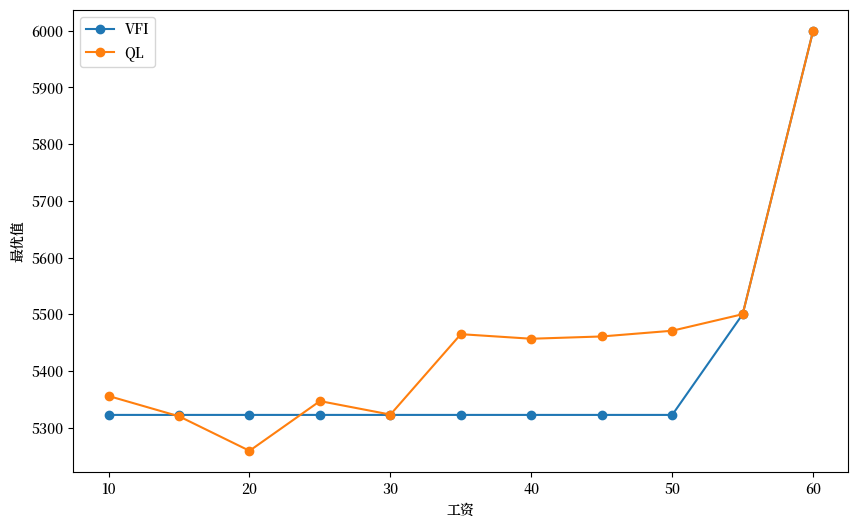

In [11]:
# 绘图
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(w_default, valfunc_VFI, '-o', label='VFI')
ax.plot(w_default, valfunc_qlr, '-o', label='QL')
ax.set_xlabel('工资')
ax.set_ylabel('最优值')
ax.legend()

plt.show()

现在，让我们计算一个更大状态空间的情况：$n=30$（而不是$n=10$）。

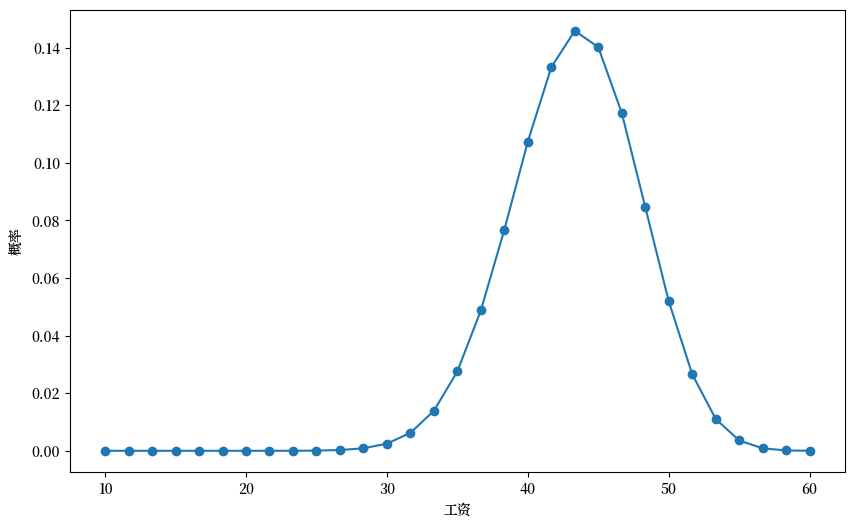

In [12]:
n, a, b = 30, 200, 100                        # 默认参数
q_new = BetaBinomial(n, a, b).pdf()           # 默认的q选择

w_min, w_max = 10, 60
w_new = np.linspace(w_min, w_max, n+1)


# 绘制工资报价分布
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(w_new, q_new, '-o', label='$q(w(i))$')
ax.set_xlabel('工资')
ax.set_ylabel('概率')

plt.show()

# 值函数迭代
mcm = McCallModel(w=w_new, q=q_new)
valfunc_VFI, flag = mcm.VFI()

In [13]:
mcm = McCallModel(w=w_new, q=q_new)
valfunc_VFI, flag = mcm.VFI()
valfunc_VFI

array([4859.77015703, 4859.77015703, 4859.77015703, 4859.77015703,
       4859.77015703, 4859.77015703, 4859.77015703, 4859.77015703,
       4859.77015703, 4859.77015703, 4859.77015703, 4859.77015703,
       4859.77015703, 4859.77015703, 4859.77015703, 4859.77015703,
       4859.77015703, 4859.77015703, 4859.77015703, 4859.77015703,
       4859.77015703, 4859.77015703, 4859.77015703, 4859.77015703,
       5000.        , 5166.66666667, 5333.33333333, 5500.        ,
       5666.66666667, 5833.33333333, 6000.        ])

In [14]:
def plot_epochs(epochs_to_plot, quit_allowed=1):
    "绘制由不断增加的训练轮数所得到的值函数。"
    qlmc_new = Qlearning_McCall(w=w_new, q=q_new, quit_allowed=quit_allowed)
    qtable = np.zeros((len(w_new),2))
    epochs_to_plot = np.asarray(epochs_to_plot)
    # 绘图
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(w_new, valfunc_VFI, '-o', label='VFI')

    max_epochs = np.max(epochs_to_plot)
    # 迭代训练轮数
    for n in range(max_epochs + 1):
        if n%(max_epochs/10)==0:
            print(f"进度: 训练轮数 = {n}")
        if n in epochs_to_plot:
            valfunc_qlr = valfunc_from_qtable(qtable)
            error = compute_error(valfunc_qlr, valfunc_VFI)

            ax.plot(w_new, valfunc_qlr, '-o', label=f'QL:训练轮数={n}, 平均误差={error}')


        new_qtable = qlmc_new.run_one_epoch(qtable)
        qtable = new_qtable

    ax.set_xlabel('工资')
    ax.set_ylabel('最优值')
    ax.legend(loc='lower right')
    plt.show()

进度: 训练轮数 = 0


进度: 训练轮数 = 20000
进度: 训练轮数 = 40000


进度: 训练轮数 = 60000
进度: 训练轮数 = 80000


进度: 训练轮数 = 100000
进度: 训练轮数 = 120000


进度: 训练轮数 = 140000
进度: 训练轮数 = 160000


进度: 训练轮数 = 180000
进度: 训练轮数 = 200000


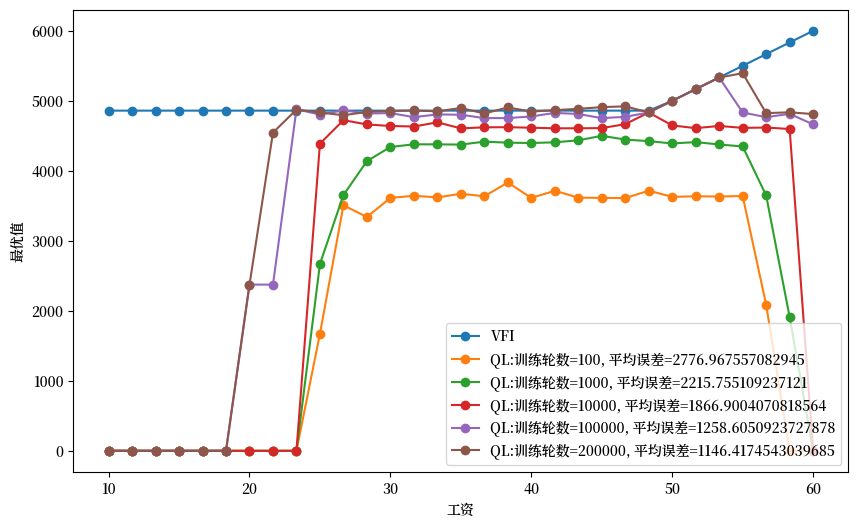

In [15]:
plot_epochs(epochs_to_plot=[100, 1000, 10000, 100000, 200000])

从上述图表中，我们可以观察到两个重要现象：

* Q-learning算法在学习较少出现的工资水平时表现不佳，这反映了算法对样本频率的依赖性

* 随着训练轮数增加，算法逐渐接近通过值函数迭代得到的"真实"值函数，表明学习质量随时间提高

## 禁止在职劳动者辞职的情况

我们之前讨论的时序差分Q-learning版本（见方程{eq}`eq:old4`）允许已就业的劳动者辞去当前工作，从而在当期获得失业补助，并在下期有机会获得新的工作offer。

这一选项在{doc}`标准McCall模型<mccall_model>`中并不存在，正如{cite}`Ljungqvist2012`第6章中关于求职搜索的分析所证明的那样。

然而，从学习算法的角度看，允许辞职选项实际上有助于加速学习过程。这是因为辞职选项促进了状态空间的探索，避免了过早地固定在某一决策上（即过早利用而非探索）。

为了展示不允许辞职的情况，我们需要修改策略公式，限制已就业劳动者必须保持其当前工作。

基于这种限制，我们可以得到以下修改后的策略值：

$$
\begin{aligned}
\widetilde{TD}\left(w,\text{accept}\right) & = \left[ w+\beta\widetilde{Q}^{old}\left(w,\text{accept}\right) \right]-\widetilde{Q}^{old}\left(w,\text{accept}\right) \\
\widetilde{TD}\left(w,\text{reject}\right) & = \left[ c+\beta\max_{a'\in\mathcal{A}}\widetilde{Q}^{old}\left(w',a'\right) \right]-\widetilde{Q}^{old}\left(w,\text{reject}\right),\;w'\sim F
\end{aligned}
$$ (eq:temp-diff)

实际上，当我们将公式{eq}`eq:temp-diff`与Q学习递归{eq}`eq:old3`结合使用时，智能体仍然能够最终学习到最优值函数，就像在允许辞职的情况下一样。

然而，这种学习过程会变得更加缓慢。这是因为一旦代理人接受了工资报价，他就失去了在当前回合中继续探索其他状态和更新相应价值估计的机会。

在训练初期阶段（即训练轮数较少时），这种限制往往会导致次优的学习结果。

不过，随着我们增加训练轮数，学习误差会逐渐减小，最终结果会越来越接近最优解。

下面的代码和图表将直观地展示这一学习过程。

进度: 训练轮数 = 0


进度: 训练轮数 = 20000


进度: 训练轮数 = 40000


进度: 训练轮数 = 60000


进度: 训练轮数 = 80000


进度: 训练轮数 = 100000


进度: 训练轮数 = 120000


进度: 训练轮数 = 140000


进度: 训练轮数 = 160000


进度: 训练轮数 = 180000


进度: 训练轮数 = 200000


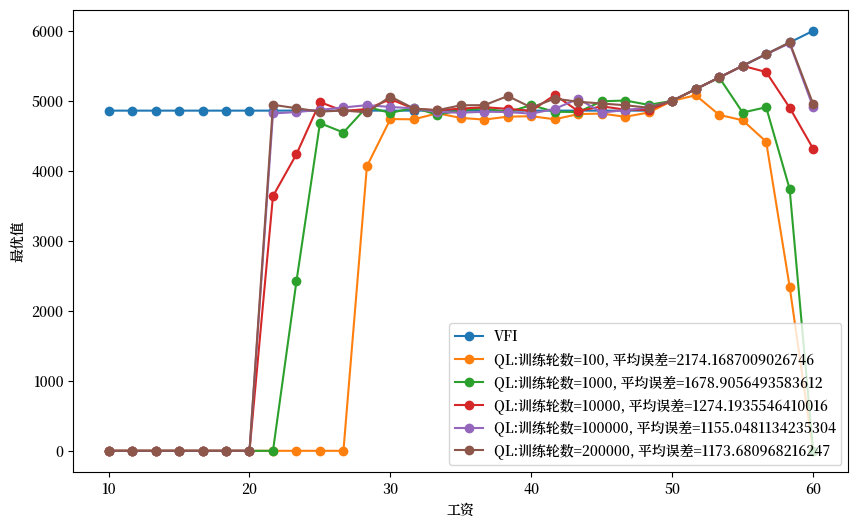

In [16]:
plot_epochs(epochs_to_plot=[100, 1000, 10000, 100000, 200000], quit_allowed=0)

## 进一步的研究方向

当我们需要处理连续状态空间的问题时，Q学习算法需要进行适当的扩展。一种常见的方法是采用特定函数形式来近似Q函数和策略函数。

这种思路发展出了**深度Q学习**（Deep Q-Learning）方法，它利用多层神经网络的强大表达能力来逼近复杂的Q函数。神经网络作为通用函数逼近器，能够有效捕捉连续状态空间中的价值信息。

在后续的quantecon课程中，我们将深入探讨深度Q学习及其在更复杂经济模型中的应用。